# Malaria Detection

In this notebook I will be building a model for detecting malaria from images of blood cells. The dataset of 27,558 cell images (equal amounts of parasitized and uninfected) were taken from Giemsa-stained thin blood smear slides.

The dataset and more information can be found at https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import itertools
from sklearn.metrics import confusion_matrix

tf.__version__

'2.0.0-beta0'

### Creating lists of paths to images.

In [2]:
base_path = "C:\\Users\\Jessy\\Downloads\\cell-images-for-detecting-malaria\\cell_images\\"

data_root_infected = pathlib.Path(base_path + "Parasitized\\")
data_root_uninfected = pathlib.Path(base_path + "Uninfected\\")

all_infected_paths = list(data_root_infected.glob('*.png'))
all_infected_paths = [str(path) for path in all_infected_paths]

all_uninfected_paths = list(data_root_uninfected.glob('*.png'))
all_uninfected_paths = [str(path) for path in all_uninfected_paths]

In [5]:
split_1 = int(0.8 * len(all_infected_paths) + len(all_uninfected_paths))

train_infected_paths = all_infected_paths[:split_1]
train_uninfected_paths = all_infected_paths[:split_1]
test_infected_paths = all_uninfected_paths[split_1:]
test_uninfected_paths = all_uninfected_paths[split_1:]

#### Image preprocessing functions.

In [6]:
size = 55

def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [size, size])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#### Preprocessing images and creating labels.  The dataset is quite small, so I am using data augmentation to create more images using rotations and random flipping.

In [7]:
cell_images = []
cell_labels = []


with tf.device('/CPU:0'):

    for item in train_infected_paths:
        image = load_and_preprocess_image(item)
        rotated_image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        flipped_image = tf.image.random_flip_left_right(image)
        flipped_image = tf.image.random_flip_up_down(flipped_image)
        cell_images.append(np.array(image))
        cell_images.append(np.array(rotated_image))
        cell_images.append(np.array(flipped_image))
        cell_labels.append(np.array(1))
        cell_labels.append(np.array(1))
        cell_labels.append(np.array(1))

    for item in train_uninfected_paths:
        image = load_and_preprocess_image(item)
        rotated_image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        flipped_image = tf.image.random_flip_left_right(image)
        flipped_image = tf.image.random_flip_up_down(flipped_image)
        cell_images.append(np.array(image))
        cell_images.append(np.array(rotated_image))
        cell_images.append(np.array(flipped_image))
        cell_labels.append(np.array(0))
        cell_labels.append(np.array(0))
        cell_labels.append(np.array(0))

In [ ]:
print("Cell Images: ", len(cell_images))

### Visualizing the images.
We can see a few of the images after preprocessing and augmentation.  It seems that the blood cells infected with malaria tend to have concentrations of discoloration.  A convolutional neural network should do well at learning these features.

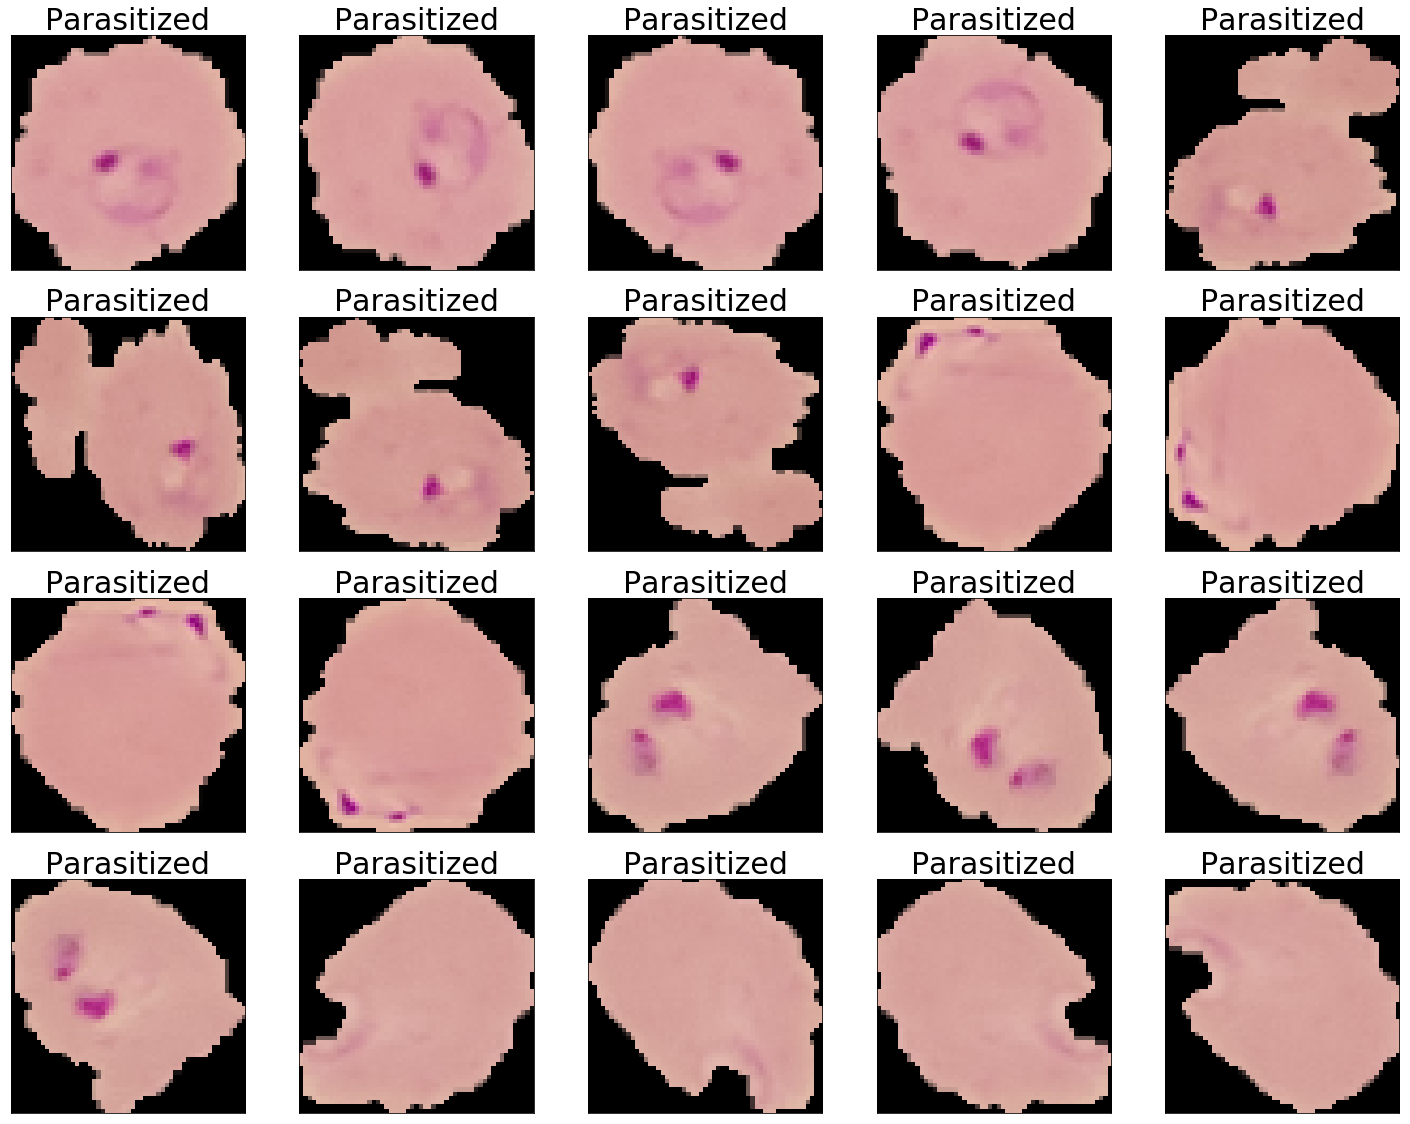

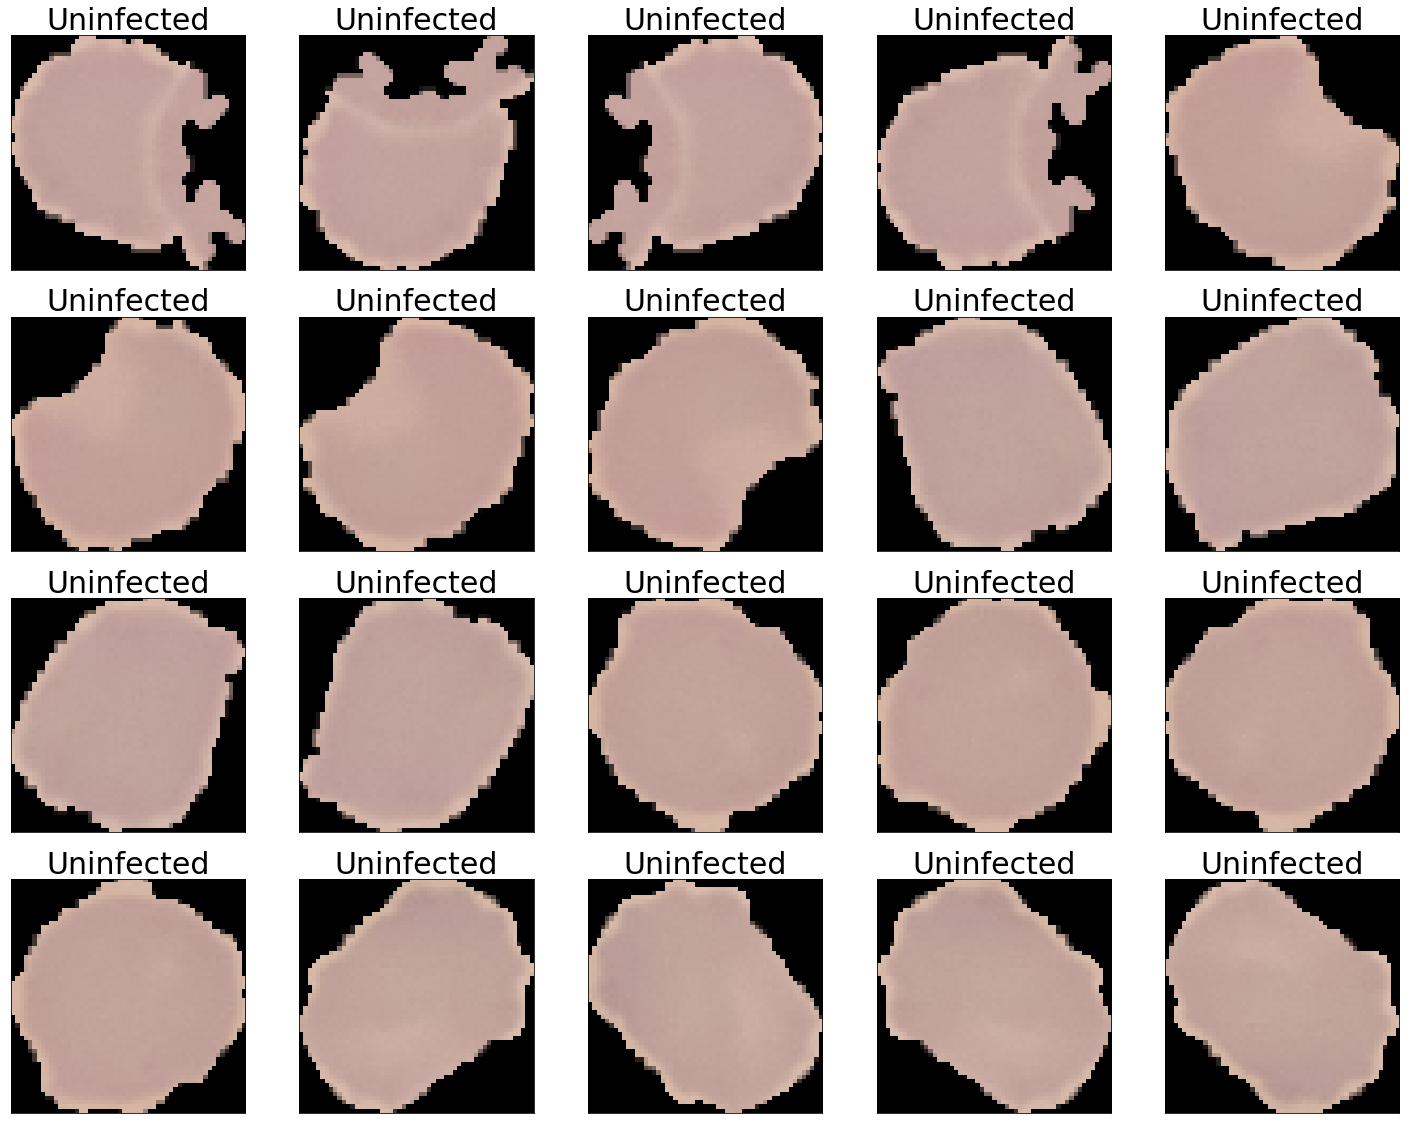

In [7]:
def visualize_images(imgs, title):    
    plt.figure(figsize=(25,25))
    for i in range(0,20,1): #large increments to skip over augmented imgs
        j = i / 1 #to adjust for subplot alignment
        plt.subplot(5,5, j+1)
        plt.imshow(imgs[i])
        plt.title(title,fontsize=30)
        plt.xticks([]) , plt.yticks([])
    plt.show()

visualize_images(cell_images, "Parasitized")
visualize_images(cell_images[len(cell_images)-1000:], "Uninfected")

### Converting into numpy arrays.

In [8]:
cells=np.array(cell_images)
labels=np.array(cell_labels)

### Shuffling images and labels in the same order.

In [9]:
def shuffle_arrays(arrays):
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    
    for arr in arrays:
        rstate = np.random.RandomState(1)
        rstate.shuffle(arr)

shuffle_arrays([cells, labels])

### Creating train/val/test split.  80/10/10

In [13]:
split_1 = int(0.8 * len(labels))
split_2 = int(0.9 * len(labels))

train_images = cells[:split_1]
train_labels = labels[:split_1]
val_images = cells[split_1:split_2]
val_labels = labels[split_1:split_2]
test_images = cells[split_2:]
test_labels = labels[split_2:]

train_image_count = len(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

88185
11023
11024


### Creating the Model.
I experimented with a quite a few different architectures, but this relatively simple model proved to give the best results.  Batch Normalization and data augmentation both helped reduce overfitting.  Multiple fully connected layers didn't improve performance.  A higher number of filters only increased training time and overfitting.

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(55,55,3), padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-07),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)       

### Training model.

In [15]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=50, verbose=1, validation_data=(val_images,val_labels))

W0629 08:29:32.936023 12092 deprecation.py:323] From c:\users\jessy\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 88185 samples, validate on 11023 samples
Epoch 1/50
88185/88185 [==============================] - 55s 626us/sample - loss: 0.1710 - accuracy: 0.9373 - val_loss: 0.1504 - val_accuracy: 0.9457
Epoch 2/50
88185/88185 [==============================] - 43s 491us/sample - loss: 0.1089 - accuracy: 0.9620 - val_loss: 0.1117 - val_accuracy: 0.9618
Epoch 3/50
88185/88185 [==============================] - 43s 490us/sample - loss: 0.0955 - accuracy: 0.9665 - val_loss: 0.1076 - val_accuracy: 0.9649
Epoch 4/50
88185/88185 [==============================] - 43s 483us/sample - loss: 0.0873 - accuracy: 0.9698 - val_loss: 0.1044 - val_accuracy: 0.9623
Epoch 5/50
88185/88185 [==============================] - 43s 484us/sample - loss: 0.0794 - accuracy: 0.9723 - val_loss: 0.1115 - val_accuracy: 0.9621
Epoch 6/50
88185/88185 [==============================] - 43s 486us/sample - loss: 0.0687 - accuracy: 0.9757 - val_loss: 0.1544 - val_accuracy: 0.9522
Epoch 7/50
88185/88185 [====================

### Testing model on unseen data.  ~96.5% accuracy.  Not bad!

In [16]:
accuracy, loss = model.evaluate(test_images, test_labels)

11024/11024 [==============================] - 4s 333us/sample - loss: 0.3093 - accuracy: 0.9652


In [29]:
predictions = model.predict(test_images)

### Plotting confusion matrix.  
Untreated malaria can be deadly, so we would like to see a very low amounts of false negatives.

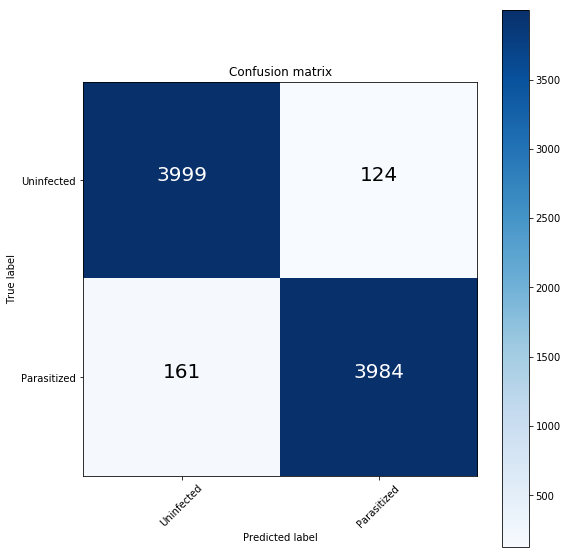

In [30]:
cm = confusion_matrix(test_labels, tf.round(predictions))
label_names = ['Uninfected','Parasitized']

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=45)
plt.yticks(tick_marks, label_names)

# Use white text if squares are dark; otherwise black.
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize=20)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Separating predictions into lists of true negatives, true positives, fasle negatives, and false positives.

In [31]:
tn_images = []
test_tn_labels = []
tn_labels = []

tp_images = []
test_tp_labels = []
tp_labels = []

fn_images = []
test_fn_labels = []
fn_labels = []

fp_images = []
test_fp_labels = []
fp_labels = []

for i in range(len(test_images)):
    if test_labels[i] == 0 and np.around(predictions[i]) == 0:
        tn_images.append(test_images[i])
        test_tn_labels.append(test_labels[i])
        tn_labels.append(int(predictions[i]))
    elif test_labels[i] == 1 and np.around(predictions[i]) == 1:
        tp_images.append(test_images[i])
        test_tp_labels.append(test_labels[i])
        tp_labels.append(np.around(predictions[i]))
    elif test_labels[i] > np.around(predictions[i]):
        fn_images.append(test_images[i])
        test_fn_labels.append(test_labels[i])
        fn_labels.append(np.around(predictions[i]))      
    else:
        fp_images.append(test_images[i])
        test_fp_labels.append(test_labels[i])
        fp_labels.append(np.around(predictions[i]))

In [32]:
def visualize_predictions(imgs, true_labels, predicted_labels, title):    
    plt.figure(1, figsize=(25,25))
    for i in range(5):
        plt.subplot(5,5, i+1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(imgs[i])
        plt.title('True {} : Pred {}'.format(true_labels[i], int(predicted_labels[i])), fontsize=25)
        plt.suptitle(title, fontsize=35,x=0.5, y=.92)
        plt.xticks([]) , plt.yticks([])
    plt.show()

#### Visualizing Predictions.
It looks like the model struggles to predict the presence of malaria when there are only small amounts of discoloration, or if the cell is uniformly discolored. 

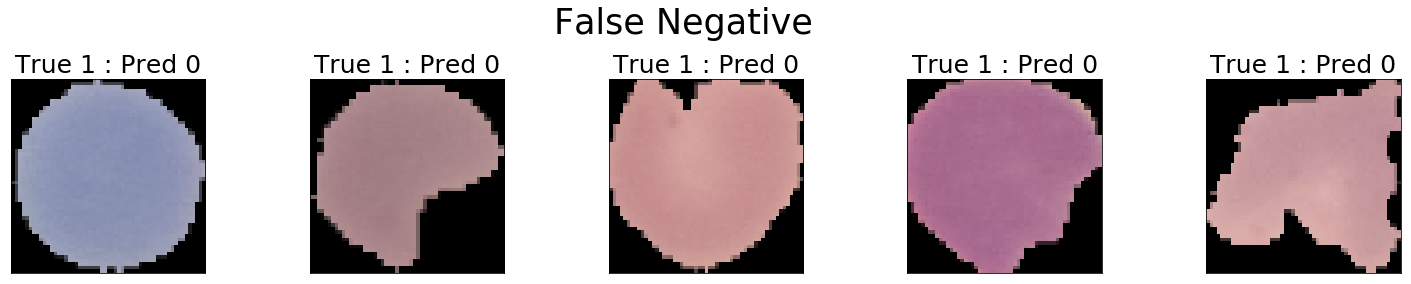

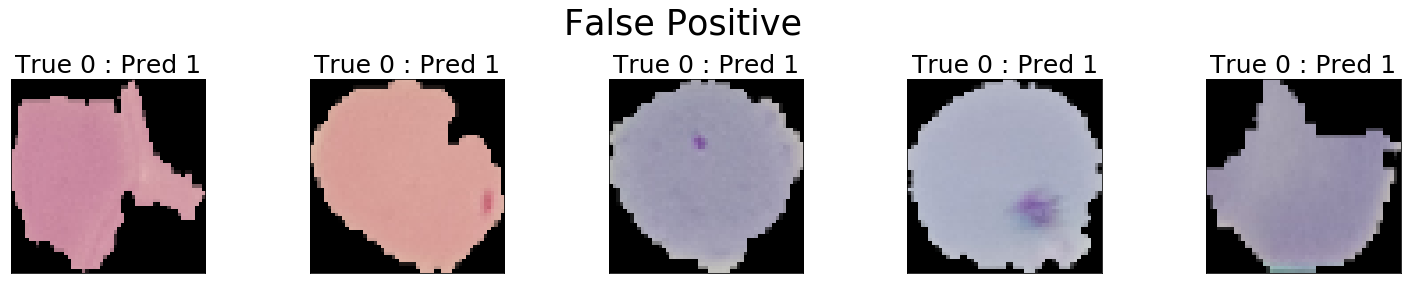

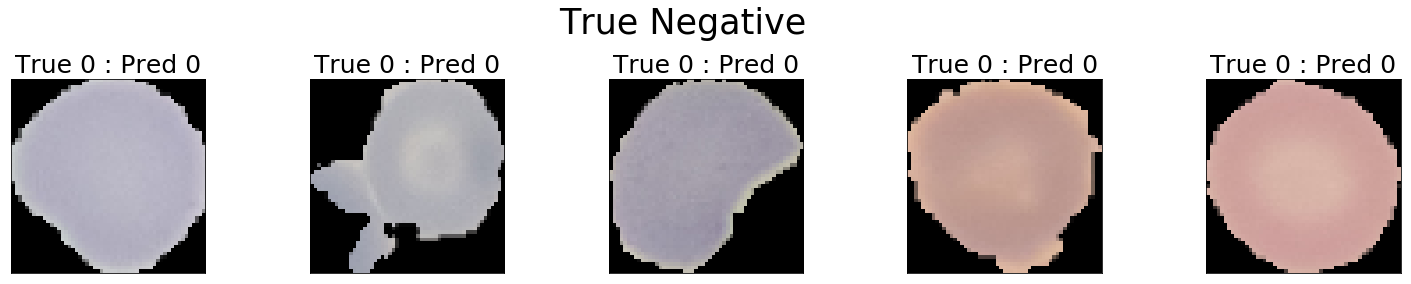

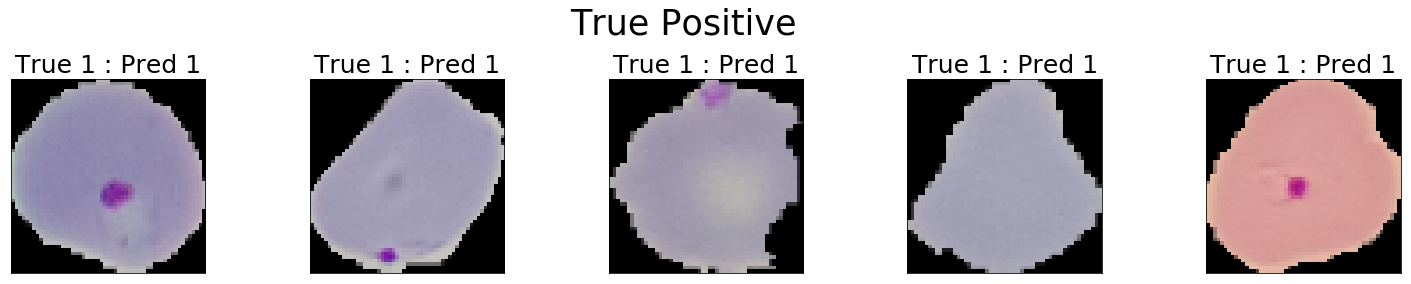

In [33]:
visualize_predictions(fn_images, test_fn_labels, fn_labels, "False Negative")
visualize_predictions(fp_images, test_fp_labels, fp_labels, "False Positive")
visualize_predictions(tn_images, test_tn_labels, tn_labels, "True Negative")
visualize_predictions(tp_images, test_tp_labels, tp_labels, "True Positive")